# Run a nm model for a single IDP

In [1]:
import os
import sys #system parameters
import glob
import numpy as np
import pandas as pd
import pickle
import shutil
from matplotlib import pyplot as plt
import statsmodels.api as sm
from scipy import optimize
import seaborn as sns
sns.set(style='whitegrid')
import seaborn as sns
sns.despine()

sys.path.append('/home/preclineu/chafra/Desktop/PCNtoolkit/') # Updated
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import create_bspline_basis, compute_MSLL

data_dir = '/project_cephfs/3022017.02/projects/big_data/data/ukb_processed_4'
save_im_path = '/project_cephfs/3022017.02//projects/big_data/results/'
idp_ids = []
with open(os.path.join(data_dir, 'idp_ids.txt'), 'r') as f:
    for line in f:
        idp_ids.append(line.strip())

<Figure size 432x288 with 0 Axes>

# Choose model settings

In [2]:
# Check https://open.win.ox.ac.uk/ukbiobank/big40/BIG40-IDPs_v3/IDPs.html for names
# Choose one IDP to model
idp_ids = ['25124-2.0']  

# which type of model to run?
cov_type = 'bspline'  # 'int', 'bspline' or None
warp = 'WarpSinArcsinh'   # 'WarpBoxCox', 'WarpSinArcsinh'  or None
sex = 0 # 1 = female 0 = male
if sex == 0: 
    clr = 'blue';
    sex_name = 'male'
else:
    clr = 'red'
    sex_name = 'female'

# cubic B-spline basis (used for regression)
xmin = 40 # boundaries for ages of UKB participants +/- 5
xmax = 85
B = create_bspline_basis(xmin, xmax)

# Import functions

In [3]:
def calibration_descriptives(x):
  n = np.shape(x)[0]
  m1 = np.mean(x)
  m2 = sum((x-m1)**2)
  m3 = sum((x-m1)**3)
  m4 = sum((x-m1)**4)
  s1 = np.std(x)
  skew = n*m3/(n-1)/(n-2)/s1**3
  sdskew = np.sqrt( 6*n*(n-1) / ((n-2)*(n+1)*(n+3)) )
  kurtosis = (n*(n+1)*m4 - 3*m2**2*(n-1)) / ((n-1)*(n-2)*(n-3)*s1**4)
  sdkurtosis = np.sqrt( 4*(n**2-1) * sdskew**2 / ((n-3)*(n+5)) )
  semean = np.sqrt(np.var(x)/n)
  sesd = s1/np.sqrt(2*(n-1))
  cd = [skew, sdskew, kurtosis, sdkurtosis, semean, sesd]
  return cd

def save_output(src_dir, dst_dir, savemodel=True):
    # move everything else to the destination dir
    files = []
    files.extend(glob.glob(os.path.join(src_dir,'Z*')))
    files.extend(glob.glob(os.path.join(src_dir,'yhat*')))
    files.extend(glob.glob(os.path.join(src_dir,'ys2*')))
    files.extend(glob.glob(os.path.join(src_dir,'Rho*')))
    files.extend(glob.glob(os.path.join(src_dir,'pRho*')))
    files.extend(glob.glob(os.path.join(src_dir,'RMSE*')))
    files.extend(glob.glob(os.path.join(src_dir,'SMSE*')))
    files.extend(glob.glob(os.path.join(src_dir,'MSLL*')))
    files.extend(glob.glob(os.path.join(src_dir,'EXPV*')))
    
    if savemodel:
        model_files = glob.glob(os.path.join(src_dir,'Models/*'))
        dst_model_dir = os.path.join(dst_dir, 'Models')
        os.makedirs(dst_model_dir, exist_ok=True)
        for f in model_files:
            fdir, fnam = os.path.split(f)
            shutil.move(f, os.path.join(dst_model_dir,fnam))
        os.rmdir(os.path.join(src_dir,'Models'))
    else:
        # remove the model directory to save space
        shutil.rmtree(os.path.join(src_dir,'Models'))
    
    for f in files:
        fdir, fnam = os.path.split(f)
        shutil.move(f, os.path.join(dst_dir,fnam))
    return

def test_func(x, epsilon, b):
        return np.sinh(b * np.arcsinh(x) + epsilon * b)

# Create dummy variables

In [4]:
# create dummy data for visualisation
xx = np.arange(xmin,xmax,0.5)
X_dummy = np.zeros((len(xx), 6))
X_dummy[:,0] = sex  # male = 1
X_dummy[:,1] = xx
X_dummy[:,2] = 1 # select certain location
np.savetxt(os.path.join(data_dir,'cov_male_dummy.txt'), X_dummy)
X_dummy = np.concatenate((X_dummy, np.ones((len(xx), 1))), axis=1) # add intercept
np.savetxt(os.path.join(data_dir,'cov_int_male_dummy.txt'), X_dummy)
X_dummy = np.concatenate((X_dummy, np.array([B(i) for i in X_dummy[:,1]])), axis=1) # add bspline
np.savetxt(os.path.join(data_dir,'cov_bspline_male_dummy.txt'), X_dummy)
if cov_type is None:
    cov_file_dummy = os.path.join(data_dir, 'cov_male_dummy.txt')
else:
    cov_file_dummy = os.path.join(data_dir, 'cov_' + cov_type + '_male_dummy.txt')

blr_metrics = pd.DataFrame(columns = ['eid', 'NLL', 'EV', 'MSLL', 'BIC'])
nummer = 0

Try different optimizers for the warp to get an optimal result: :param optimizer: optimisation algorithm ('cg','powell','nelder-mead','l0bfgs-b')

In [5]:
for idp in idp_ids: 
    nummer = nummer + 1
    print(nummer)
    print('Running IDP:', idp)
    idp_dir = os.path.join(data_dir, idp)
    os.chdir(idp_dir)
    
    # set output dir 
    out_name = 'blr'
    if cov_type is not None:
        out_name += '_' + cov_type
    if warp is not None:
        out_name += '_' + warp
    os.makedirs(os.path.join(idp_dir,out_name), exist_ok=True)
    
    # load data matrices
    X_tr = np.loadtxt(os.path.join(idp_dir, 'cov_tr.txt'))
    X_te = np.loadtxt(os.path.join(idp_dir, 'cov_te.txt'))

    # add intercept column 
    X_tr = np.concatenate((X_tr, np.ones((X_tr.shape[0],1))), axis=1)
    X_te = np.concatenate((X_te, np.ones((X_te.shape[0],1))), axis=1)
    np.savetxt(os.path.join(idp_dir, 'cov_int_tr.txt'), X_tr)
    np.savetxt(os.path.join(idp_dir, 'cov_int_te.txt'), X_te)
    
    # create Bspline basis set 
    Phi = np.array([B(i) for i in X_tr[:,1]])
    Phis = np.array([B(i) for i in X_te[:,1]])
    X_tr = np.concatenate((X_tr, Phi), axis=1)
    X_te = np.concatenate((X_te, Phis), axis=1)
    np.savetxt(os.path.join(idp_dir, 'cov_bspline_tr.txt'), X_tr)
    np.savetxt(os.path.join(idp_dir, 'cov_bspline_te.txt'), X_te)
    
    # configure the covariates to use
    if cov_type is None:
        cov_file_tr = os.path.join(idp_dir, 'cov_tr.txt')
        cov_file_te = os.path.join(idp_dir, 'cov_te.txt')
    else:
        cov_file_tr = os.path.join(idp_dir, 'cov_') + cov_type + '_tr.txt'
        cov_file_te = os.path.join(idp_dir, 'cov_') + cov_type + '_te.txt'
    resp_file_tr = os.path.join(idp_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    resp_tr_skew = calibration_descriptives(np.loadtxt(resp_file_tr))[0]
    
    # run a basic model
    # [mod] specify starting hyperparamters using OLS
    y_tr = np.loadtxt(resp_file_tr)
    y_tr = y_tr[:, np.newaxis]
    hyp0 = np.zeros(4)
 
    
    if warp == None:
        estimate(cov_file_tr, resp_file_tr, testresp=resp_file_te, 
              testcov=cov_file_te, alg='blr', configparam=1,
              optimizer = 'powell', savemodel=True, standardize = False)
    else: 
        estimate(cov_file_tr, resp_file_tr, testresp=resp_file_te, 
              testcov=cov_file_te, alg='blr', configparam=1,verbose=True,
              optimizer = 'powell', savemodel=True, standardize = False, warp=warp, theta=hyp0) # if verbose true see inbetween estimates 
    
    # create dummy predictions for visualistion
    yhat, s2 = predict(cov_file_dummy, respfile=None, alg='blr')

    with open(os.path.join(idp_dir, 'Models/','NM_0_0_estimate.pkl'), 'rb') as handle:
       nm = pickle.load(handle)

1
Running IDP: 25124-2.0
Processing data in /project_cephfs/3022017.02/projects/big_data/data/ukb_processed_4/25124-2.0/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
warp: <pcntoolkit.util.utils.WarpSinArcsinh object at 0x7fc75193eeb0> warp_reparam: False
warping input...
estimating posterior ... | hyp= [0. 0. 0. 0.]
nlZ=  3717.355775929811  | hyp= [0. 0. 0. 0.]
warping input...
nlZ=  3717.355775929811  | hyp= [0. 0. 0. 0.]
warping input...
estimating posterior ... | hyp= [1. 0. 0. 0.]
nlZ=  1715.1043511168841  | hyp= [1. 0. 0. 0.]
warping input...
estimating posterior ... | hyp= [2.618034 0.       0.       0.      ]
nlZ=  -1524.1578581837305  | hyp= [2.618034 0.       0.       0.      ]
warping input...
estimating posterior ... | hyp= [178.98374   0.        0.        0.     ]
nlZ=  1.2092856495637037e+72  | hyp= [178.98374   0.        0.        0.     ]
warping input...
estimating posterior ... | hyp= [2.618034 0.       0.       0.      ]
nlZ=  -1524.1578581837305  

/home/preclineu/chafra/Desktop/PCNtoolkit/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0011e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/chafra/Desktop/PCNtoolkit/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.32586e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/chafra/Desktop/PCNtoolkit/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.80504e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/chafra/Desktop/PCNtoolkit/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.95807e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/chafra/Desktop/PCNtoolkit/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=

  | hyp= [20.59673105  0.12049045  0.          0.        ]
warping input...
estimating posterior ... | hyp= [20.59673105  0.12284631  0.          0.        ]
nlZ=  -35532.59236312974  | hyp= [20.59673105  0.12284631  0.          0.        ]
warping input...
estimating posterior ... | hyp= [20.59673105  0.12407477  0.          0.        ]
nlZ=  -35532.59217987054  | hyp= [20.59673105  0.12407477  0.          0.        ]
warping input...
estimating posterior ... | hyp= [20.59673105  0.12284631  0.          0.        ]
nlZ=  -35532.59236312974  | hyp= [20.59673105  0.12284631  0.          0.        ]
warping input...
estimating posterior ... | hyp= [20.59673105  0.12284631  1.          0.        ]
nlZ=  -25427.50307980503  | hyp= [20.59673105  0.12284631  1.          0.        ]
warping input...
estimating posterior ... | hyp= [20.59673105  0.12284631 -1.618034    0.        ]
nlZ=  -30937.64702903333  | hyp= [20.59673105  0.12284631 -1.618034    0.        ]
warping input...
estimating pos

/home/preclineu/chafra/Desktop/PCNtoolkit/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.45708e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


 -34122.86119275833  | hyp= [2.15967310e+01 1.22846312e-01 1.00000000e-11 7.76540671e+00]
warping input...
estimating posterior ... | hyp= [1.89786970e+01 1.22846312e-01 1.00000000e-11 7.76540671e+00]
nlZ=  -33940.47560495608  | hyp= [1.89786970e+01 1.22846312e-01 1.00000000e-11 7.76540671e+00]
warping input...
estimating posterior ... | hyp= [2.05967310e+01 1.22846312e-01 1.00000000e-11 7.76540671e+00]
nlZ=  -35569.94056028839  | hyp= [2.05967310e+01 1.22846312e-01 1.00000000e-11 7.76540671e+00]
warping input...
estimating posterior ... | hyp= [1.99786971e+01 1.22846312e-01 1.00000000e-11 7.76540671e+00]
nlZ=  -35258.16308889039  | hyp= [1.99786971e+01 1.22846312e-01 1.00000000e-11 7.76540671e+00]
warping input...
estimating posterior ... | hyp= [2.09786970e+01 1.22846312e-01 1.00000000e-11 7.76540671e+00]
nlZ=  -35400.8681488232  | hyp= [2.09786970e+01 1.22846312e-01 1.00000000e-11 7.76540671e+00]
warping input...
estimating posterior ... | hyp= [2.05540347e+01 1.22846312e-01 1.00000

nlZ=  -35608.69219873374  | hyp= [ 2.05912526e+01 -7.14396945e-04 -6.87871393e-02  1.82819301e+01]
warping input...
estimating posterior ... | hyp= [ 2.05912526e+01 -7.14396945e-04  7.40463509e-04  1.82819301e+01]
nlZ=  -35632.18932564809  | hyp= [ 2.05912526e+01 -7.14396945e-04  7.40463509e-04  1.82819301e+01]
warping input...
estimating posterior ... | hyp= [ 2.05912526e+01 -7.14396945e-04  1.06526784e-02  1.82819301e+01]
nlZ=  -35632.55763027128  | hyp= [ 2.05912526e+01 -7.14396945e-04  1.06526784e-02  1.82819301e+01]
warping input...
estimating posterior ... | hyp= [ 2.05912526e+01 -7.14396945e-04  1.03579215e-02  1.82819301e+01]
nlZ=  -35632.55798672094  | hyp= [ 2.05912526e+01 -7.14396945e-04  1.03579215e-02  1.82819301e+01]
warping input...
estimating posterior ... | hyp= [ 2.05912526e+01 -7.14396945e-04  1.03444391e-02  1.82819301e+01]
nlZ=  -35632.55798634057  | hyp= [ 2.05912526e+01 -7.14396945e-04  1.03444391e-02  1.82819301e+01]
warping input...
estimating posterior ... | h

nlZ=  -31087.2179621683  | hyp= [ 2.05891928e+01 -6.99772344e-04 -1.60767608e+00  2.41463263e+01]
warping input...
estimating posterior ... | hyp= [ 2.05891928e+01 -6.99772344e-04  1.03579215e-02  2.41463263e+01]
nlZ=  -35654.32419723295  | hyp= [ 2.05891928e+01 -6.99772344e-04  1.03579215e-02  2.41463263e+01]
warping input...
estimating posterior ... | hyp= [ 2.05891928e+01 -6.99772344e-04 -6.07676053e-01  2.41463263e+01]
nlZ=  -34597.153545483685  | hyp= [ 2.05891928e+01 -6.99772344e-04 -6.07676053e-01  2.41463263e+01]
warping input...
estimating posterior ... | hyp= [ 2.05891928e+01 -6.99772344e-04  3.92323921e-01  2.41463263e+01]
nlZ=  -34886.59261942991  | hyp= [ 2.05891928e+01 -6.99772344e-04  3.92323921e-01  2.41463263e+01]
warping input...
estimating posterior ... | hyp= [ 2.05891928e+01 -6.99772344e-04 -6.87780413e-02  2.41463263e+01]
nlZ=  -35630.39997500508  | hyp= [ 2.05891928e+01 -6.99772344e-04 -6.87780413e-02  2.41463263e+01]
warping input...
estimating posterior ... | h

# load and plot the true test data points

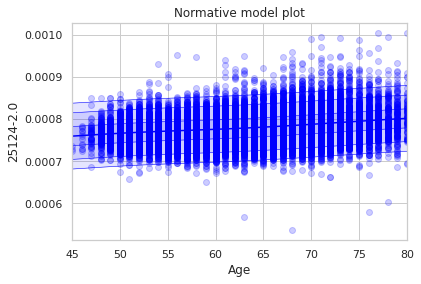

In [6]:
X_te = np.loadtxt(cov_file_te)
y_te = np.loadtxt(resp_file_te)
y_te = y_te[:, np.newaxis]
idx = np.where(X_te[:,0] == sex)
plt.figure()
plt.scatter(X_te[idx,1], y_te[idx], color=clr, alpha = 0.2)

# load training data (needed for MSLL)
if warp is None:
    plt.plot(xx, yhat, color = clr)
    #plt.fill_between(xx, np.squeeze(yhat-1.96*np.sqrt(s2)), 
    #                 np.squeeze(yhat+1.96*np.sqrt(s2)), 
    #                 color='red', alpha = 0.2)
    plt.fill_between(xx, np.squeeze(yhat-0.67*np.sqrt(s2)), 
                     np.squeeze(yhat+0.67*np.sqrt(s2)), 
                     color=clr, alpha = 0.1)
    plt.fill_between(xx, np.squeeze(yhat-1.64*np.sqrt(s2)), 
                     np.squeeze(yhat+1.64*np.sqrt(s2)), 
                     color=clr, alpha = 0.1)
    plt.fill_between(xx, np.squeeze(yhat-2.33*np.sqrt(s2)), 
                     np.squeeze(yhat+2.32*np.sqrt(s2)), 
                     color=clr, alpha = 0.1)
    plt.plot(xx, np.squeeze(yhat-0.67*np.sqrt(s2)),color=clr, linewidth=0.5)
    plt.plot(xx, np.squeeze(yhat+0.67*np.sqrt(s2)),color=clr, linewidth=0.5)
    plt.plot(xx, np.squeeze(yhat-1.64*np.sqrt(s2)),color=clr, linewidth=0.5)
    plt.plot(xx, np.squeeze(yhat+1.64*np.sqrt(s2)),color=clr, linewidth=0.5)
    plt.plot(xx, np.squeeze(yhat-2.33*np.sqrt(s2)),color=clr, linewidth=0.5)
    plt.plot(xx, np.squeeze(yhat+2.32*np.sqrt(s2)),color=clr, linewidth=0.5)

    # load test data
    yhat_te = np.loadtxt(os.path.join(idp_dir, 'yhat_estimate.txt'))
    s2_te = np.loadtxt(os.path.join(idp_dir, 'ys2_estimate.txt'))
    yhat_te = yhat_te[:, np.newaxis]
    s2_te = s2_te[:, np.newaxis]

    # compute evaluation metrics
    metrics = evaluate(y_te, yhat_te)  

    # compute MSLL manually as a sanity check
    y_tr_mean = np.array( [[np.mean(y_tr)]] )
    y_tr_var = np.array( [[np.var(y_tr)]] )
    MSLL = compute_MSLL(y_te, yhat_te, s2_te, y_tr_mean, y_tr_var)
else:
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
    W = nm.blr.warp

    # warp and plot dummy predictions
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.plot(xx, med, clr)
    #plt.fill_between(xx, pr_int[:,0], pr_int[:,1], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

    # load test data
    yhat_te = np.loadtxt(os.path.join(idp_dir, 'yhat_estimate.txt'))
    s2_te = np.loadtxt(os.path.join(idp_dir, 'ys2_estimate.txt'))
    yhat_te = yhat_te[:, np.newaxis]
    s2_te = s2_te[:, np.newaxis]

    # warp predictions
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]

    # evaluation metrics
    metrics = evaluate(y_te, med_te)

    # compute MSLL manually
    y_te_w = W.f(y_te, warp_param)
    y_tr_w = W.f(y_tr, warp_param)
    y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
    y_tr_var = np.array( [[np.var(y_tr_w)]] )
    MSLL = compute_MSLL(y_te_w, yhat_te, s2_te, y_tr_mean, y_tr_var)     
    
plt.xlim((45,80))
if idp_ids == ['25046-2.0']:
    plt.ylim(round(y_te.min()*2),round(y_te.max()*2))
    plt.xlabel('Age')
    plt.ylabel('WMH volume ($mm^3$)') 
else:
    plt.xlabel('Age')
    plt.ylabel(idp) 
plt.savefig(os.path.join(idp_dir, out_name, 'normative_model_plot'),  bbox_inches='tight')
# if warp == 'WarpSinArcsinh':
#     plt.savefig(save_im_path +'idp_'+ idp_ids[0]+ '_warp_'+sex_name+'.png',  bbox_inches='tight')
# else:
#     plt.savefig(save_im_path +'idp_'+ idp_ids[0]+ '_bspline_'+sex_name+'.png',  bbox_inches='tight')
plt.title('Normative model plot')
plt.show()
#plt.clf()

NLL = -35654.33313197723
BIC = -71275.47608983704
EV =  [0.08403554]
MSLL =  [-0.04357828]


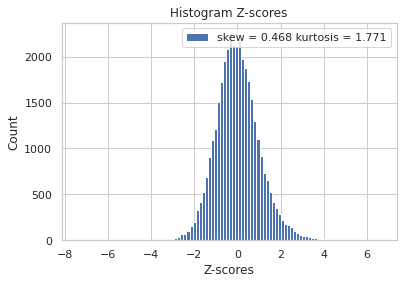

<Figure size 432x288 with 0 Axes>

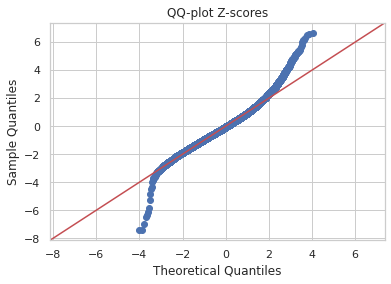

In [7]:
BIC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik

# print -log(likelihood)
print('NLL =', nm.neg_log_lik)
print('BIC =', BIC)
print('EV = ', metrics['EXPV'])
print('MSLL = ', MSLL) 

blr_metrics.loc[len(blr_metrics)] = [idp, nm.neg_log_lik, 
                                     metrics['EXPV'][0], MSLL[0], BIC]

# save blr stuff
# 
save_output(idp_dir, os.path.join(idp_dir, out_name))
Z = np.loadtxt(os.path.join(idp_dir, out_name, 'Z_estimate.txt'))
# remove biggest outlier
# Z = Z[Z!=Z.min()]
[skew, sdskew, kurtosis, sdkurtosis, semean, sesd] = calibration_descriptives(Z)
plt.figure()
plt.hist(Z, bins = 100, label = 'skew = ' + str(round(skew,3)) + ' kurtosis = ' + str(round(kurtosis,3)))
plt.title('Histogram Z-scores')
plt.xlabel('Z-scores')
plt.ylabel('Count')
plt.legend()
plt.savefig(os.path.join(idp_dir, out_name, 'Z_hist'),  bbox_inches='tight')
plt.show()

plt.figure()
sm.qqplot(Z, line = '45')
plt.title('QQ-plot Z-scores')
plt.savefig(os.path.join(idp_dir, out_name, 'Z_qq'),  bbox_inches='tight')
plt.show()
#blr_metrics.to_pickle(os.path.join(data_dir,'metrics_' + out_name + '.pkl'))

[-0.00069977  0.01046276]
[ 2.05891928e+01 -6.99772344e-04  1.04627559e-02  2.42215792e+01]


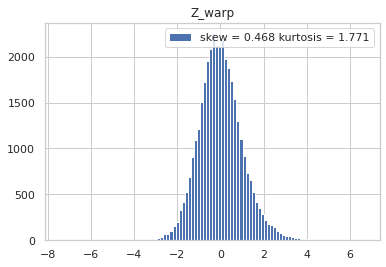

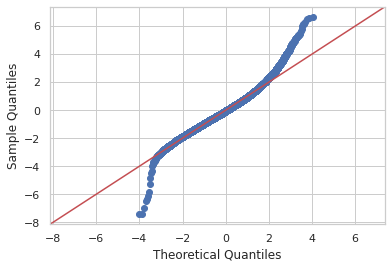

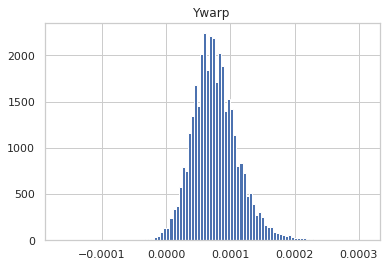

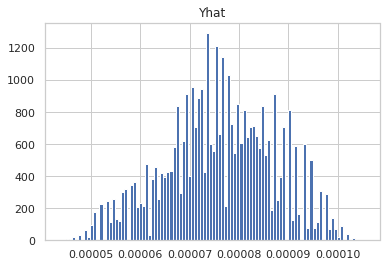

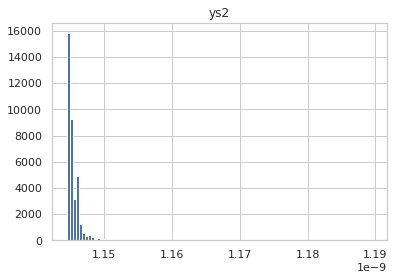

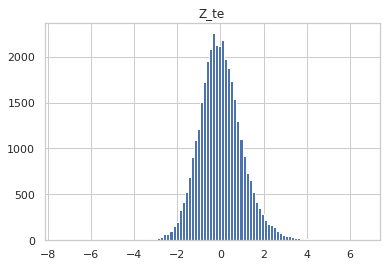

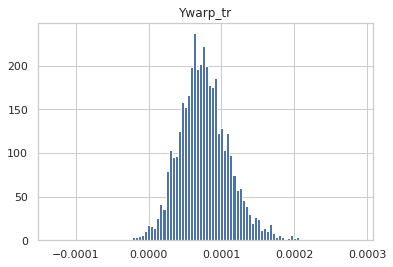

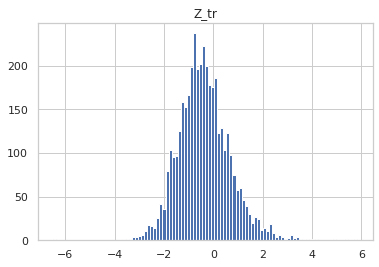

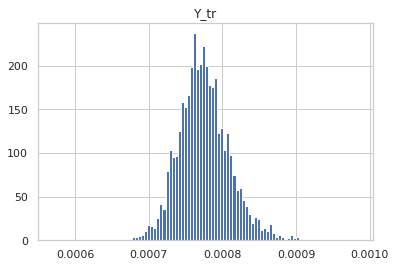

In [8]:
if warp is None:
    out_name_bspline = 'blr_bspline'
    Z = np.loadtxt(os.path.join(idp_dir, out_name, 'Z_estimate.txt'))
    [skew, sdskew, kurtosis, sdkurtosis, semean, sesd] = calibration_descriptives(Z)
    plt.figure()
    plt.hist(Z, bins = 100, label = 'skew = ' + str(round(skew,3)) + ' kurtosis = ' + str(round(kurtosis,3)))
    plt.title('Z')
    plt.legend()
    
    te = np.loadtxt(os.path.join(idp_dir, 'resp_te.txt'))
    plt.figure()
    plt.hist(te, bins = 100)
    plt.title('te')
    
    sm.qqplot(Z, line = '45')
    
    yhat = np.loadtxt(os.path.join(idp_dir, out_name, 'yhat_estimate.txt'))
    plt.figure()
    plt.hist(yhat, bins = 100)
    plt.title('Yhat')
    print(nm.blr.hyp)

else: 
    
    Z = np.loadtxt(os.path.join(idp_dir, out_name, 'Z_estimate.txt'))
    # remove biggest outlier
    # Z = Z[Z!=Z.min()]
    [skew, sdskew, kurtosis, sdkurtosis, semean, sesd] = calibration_descriptives(Z)
    plt.figure()
    plt.hist(Z, bins = 100, label = 'skew = ' + str(round(skew,3)) + ' kurtosis = ' + str(round(kurtosis,3)))
    plt.title('Z_warp')
    plt.legend()
    
    sm.qqplot(Z, line = '45')
    
    te = np.loadtxt(os.path.join(idp_dir, 'resp_te.txt'))
    Ywarp = nm.blr.warp.f(te, warp_param)
    plt.figure()
    plt.hist(Ywarp, bins = 100)
    plt.title('Ywarp')
    
    yhat = np.loadtxt(os.path.join(idp_dir, out_name, 'yhat_estimate.txt'))
    plt.figure()
    plt.hist(yhat, bins = 100)
    plt.title('Yhat')
    
    ys2 = np.loadtxt(os.path.join(idp_dir, out_name, 'ys2_estimate.txt'))
    plt.figure()
    plt.hist(ys2, bins = 100)
    plt.title('ys2')
    
    Z_calculated = (Ywarp-yhat)/np.sqrt(ys2)
    plt.figure()
    plt.hist(Z_calculated, bins = 100)
    plt.title('Z_te')
    
    tr = np.loadtxt(resp_file_tr)
    Ywarp_tr = nm.blr.warp.f(tr, warp_param)
    plt.figure()
    plt.hist(Ywarp_tr, bins = 100)
    plt.title('Ywarp_tr')
    yhat_tr = [yhat[0]]* len(Ywarp_tr)
    ys2_tr = [ys2[0]] * len(Ywarp_tr)
    
    Z_train_data = (Ywarp_tr-yhat_tr)/np.sqrt(ys2_tr)
    plt.figure()
    plt.hist(Z_train_data, bins = 100)
    plt.title('Z_tr')
    
    resp_tr = np.loadtxt(os.path.join(idp_dir, 'resp_tr.txt')) 
    plt.figure()
    plt.hist(resp_tr, bins = 100)
    plt.title('Y_tr')    
    
    print(warp_param)

print(nm.blr.hyp)